In [1]:
import dataloader
import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn import neighbors

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

%load_ext autoreload
%autoreload 2

path = "../032721Comparison/Data/SONY2021.csv"
date = datetime.datetime(2021,3,12)
count = 1200
# We will use the previous 60 days as features
history_size = 60

In [2]:
# Compute MAE
def mae(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

def rmse(y_hat, y):
    # root mean squared error
    return np.sqrt(np.mean(np.power((y-y_hat),2)))

In [3]:
df = dataloader.load_data_up_to_date(path, date, count)

(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)


In [4]:
sony_closing_all = df['Close'].to_numpy()
# reshape to 1200 x 1 matrix
sony_closing_all = np.reshape(sony_closing_all, (sony_closing_all.shape[0], -1))
sony_closing_all.shape

(1200, 1)

In [5]:
#converting prices to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(sony_closing_all)
train = scaled_data[:1000,:]
test = scaled_data[1000:, :]

In [6]:
train_x, train_y = [], []
test_x, test_y = [], []
for i in range(history_size,len(train)):
    train_x.append(scaled_data[i-history_size:i,0])
    train_y.append(scaled_data[i,0])
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1]))
print(train_x.shape)

for i in range(len(train),len(scaled_data)):
    test_x.append(scaled_data[i-history_size:i,0])
    test_y.append(scaled_data[i,0])
test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1]))
print(test_x.shape)



(940, 60)
(200, 60)


In [7]:
N_NEIGHBORS = [3, 5, 10, 20, 25]

# Vars to store results
cval_errs = {}
train_time = {}
best_af_nn_regressor = None
best_err = sys.maxsize

for nn in N_NEIGHBORS:
    kf = KFold(n_splits=5, random_state=None, shuffle=False)
    y_err = []

    start = time.time()

    # Cross Validaiton
    for train_index, val_index in kf.split(train_x):
    #     print("TRAIN:", train_index, "VAL:", val_index)
        X_train, X_val = train_x[train_index], train_x[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]

        NNRegressor = neighbors.KNeighborsRegressor(n_neighbors=nn)
        y_hat = NNRegressor.fit(X_train, y_train).predict(X_val)
    #     print(y_hat)
        y_err.append(rmse(y_hat, y_val))

    end = time.time()

    print(str(nn), "mean val RMSE:", np.mean(y_err))
    print("Time lapsed", str((end - start)*1000))

    # add to dict
    cval_errs[str(nn)] = np.mean(y_err)
    train_time[str(nn)] = (end - start)*1000
    if np.mean(y_err) < best_err:
        best_af_nn_regressor = neighbors.KNeighborsRegressor(n_neighbors=nn)
        best_af_nn_regressor = best_af_nn_regressor.fit(train_x, train_y)
        best_err = np.mean(y_err)

print(best_af_nn_regressor, best_err)

3 mean val RMSE: 0.054277425415345346
Time lapsed 54.0461540222168
5 mean val RMSE: 0.055064863111130194
Time lapsed 54.25596237182617
10 mean val RMSE: 0.05516291126146089
Time lapsed 56.54144287109375
20 mean val RMSE: 0.057009395215569234
Time lapsed 60.32824516296387
25 mean val RMSE: 0.05761076176320692
Time lapsed 62.71862983703613
KNeighborsRegressor(n_neighbors=3) 0.054277425415345346


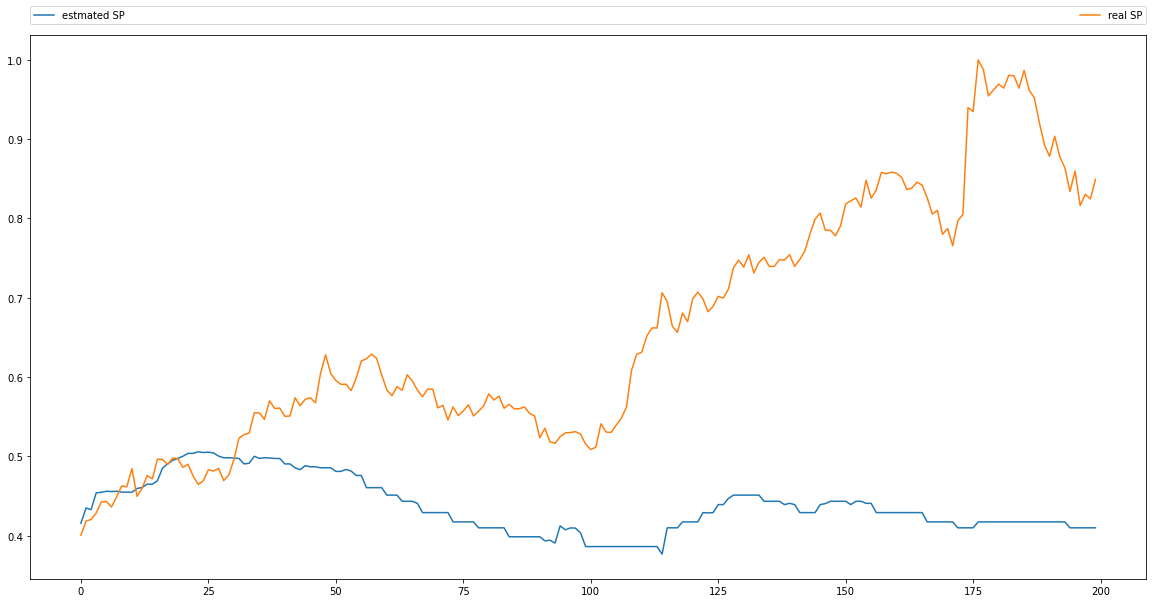

In [8]:
best_af_nn_regressor = best_af_nn_regressor.fit(train_x, train_y)
y_hat = best_af_nn_regressor.predict(test_x)
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [9]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.22500483331479232
RMSE:  0.27788400512431216
